# ERA5-Land Monthly Averaged (Use case)

## Import Necessary Libraries


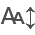

In [1]:
import os

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import math as ma
from shapely.vectorized import contains

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

## Manage Working Directories

In [2]:
# The directories (if doesn't exist) will be created in the Data folder
download_folder = r".\data\era5-land-monthly-means\download"
working_folder = r".\data\era5-land-monthly-means\working"
output_folder = r".\data\era5-land-monthly-means\output"

## Read the downloaded dataset

## Variable: snow cover

In [3]:
filename = r"reanalysis-era5-land-monthly-means_snow_cover_1950_2024.nc"
filepath = os.path.join(download_folder,filename)
dataset = nc.Dataset(filepath, mode='r')
variables_list = dataset.variables.keys()

# Read primary variable (if only 1 variable present in the netcdf file)
max_dims = 0
for var in variables_list:
    variable_obj = dataset.variables[var]
    num_dims = len(variable_obj.dimensions)
    if num_dims > max_dims:
        max_dims = num_dims
        primary_variable = var
        
lon_list = dataset['longitude']
lat_list = dataset['latitude']
variable_data = dataset[primary_variable]

## Create Basic Single Plot

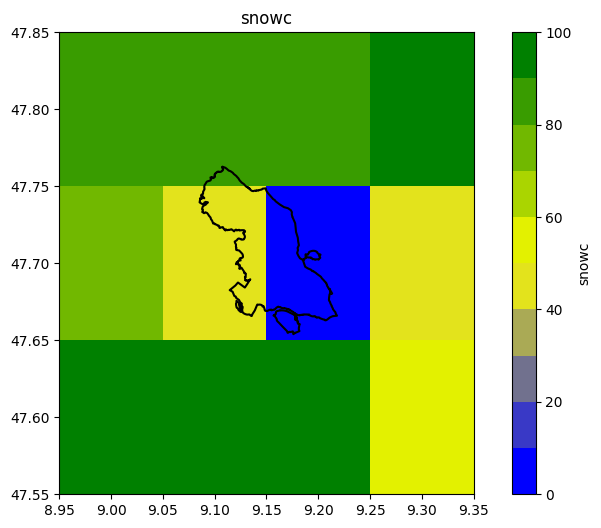

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Select year to plot
selected_year = 1970
selected_month = 1
band_index = (selected_year - 1950)*12 + (selected_month-1)

band_data = variable_data[band_index,:,:]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# # predefined cmap
# cmap = plt.get_cmap('turbo', 10)

# Custom cmap
colors = ['blue', 'yellow', 'green']
cmap = LinearSegmentedColormap.from_list("green_to_blue", colors, 10)

mesh = ax.pcolormesh(lon_list, 
                     lat_list,
                     band_data,
                     cmap=cmap,
                     vmin=0,
                     vmax=100)

plt.colorbar(mesh, ax=ax, label=f'{primary_variable}')
ax.set_title(f'{primary_variable}')

# Add administrative boundary of Konstanz
germany_shp = r".\data\shapefile\kn_boundary.shp"
germany_boundary = gpd.read_file(germany_shp)
germany_boundary.boundary.plot(ax=ax, edgecolor='black')

plt.show()

## Interpolate to higher resolution

In [5]:
from scipy.interpolate import RegularGridInterpolator

interval = 0.005

lon_new = np.arange(np.min(lon_list), np.max(lon_list), interval)
lat_new = np.arange(np.min(lat_list), np.max(lat_list) + interval, interval)
lon_new, lat_new = np.meshgrid(lon_new, lat_new[::-1])

interpolator = RegularGridInterpolator((lat_list[:], lon_list[:]),
                                       band_data,
                                       method='linear',
                                       bounds_error=False,
                                       fill_value=None)

# Evaluate on the new grid
interpolated_data = interpolator((lat_new, lon_new))
interpolated_data = np.round(interpolated_data, decimals=4)

In [6]:
# Administrative boundary of Germany
germany_shp = r".\data\shapefile\kn_boundary.shp"
germany_boundary = gpd.read_file(germany_shp)

# Create buffer
germany_boundary_buffered = germany_boundary.copy()
germany_boundary_buffered['geometry'] = germany_boundary.geometry.buffer(interval/2, cap_style=1)

germany_polygon = germany_boundary.union_all()
mask = contains(germany_polygon, lon_new, lat_new)
masked_data = np.where(mask, interpolated_data, np.nan)

germany_polygon_buffered = germany_boundary_buffered.union_all()
mask_buffered = contains(germany_polygon_buffered, lon_new, lat_new)
masked_data_buffered = np.where(mask_buffered, interpolated_data, np.nan)

G:\Temp\ipykernel_36924\1579551353.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  germany_boundary_buffered['geometry'] = germany_boundary.geometry.buffer(interval/2, cap_style=1)


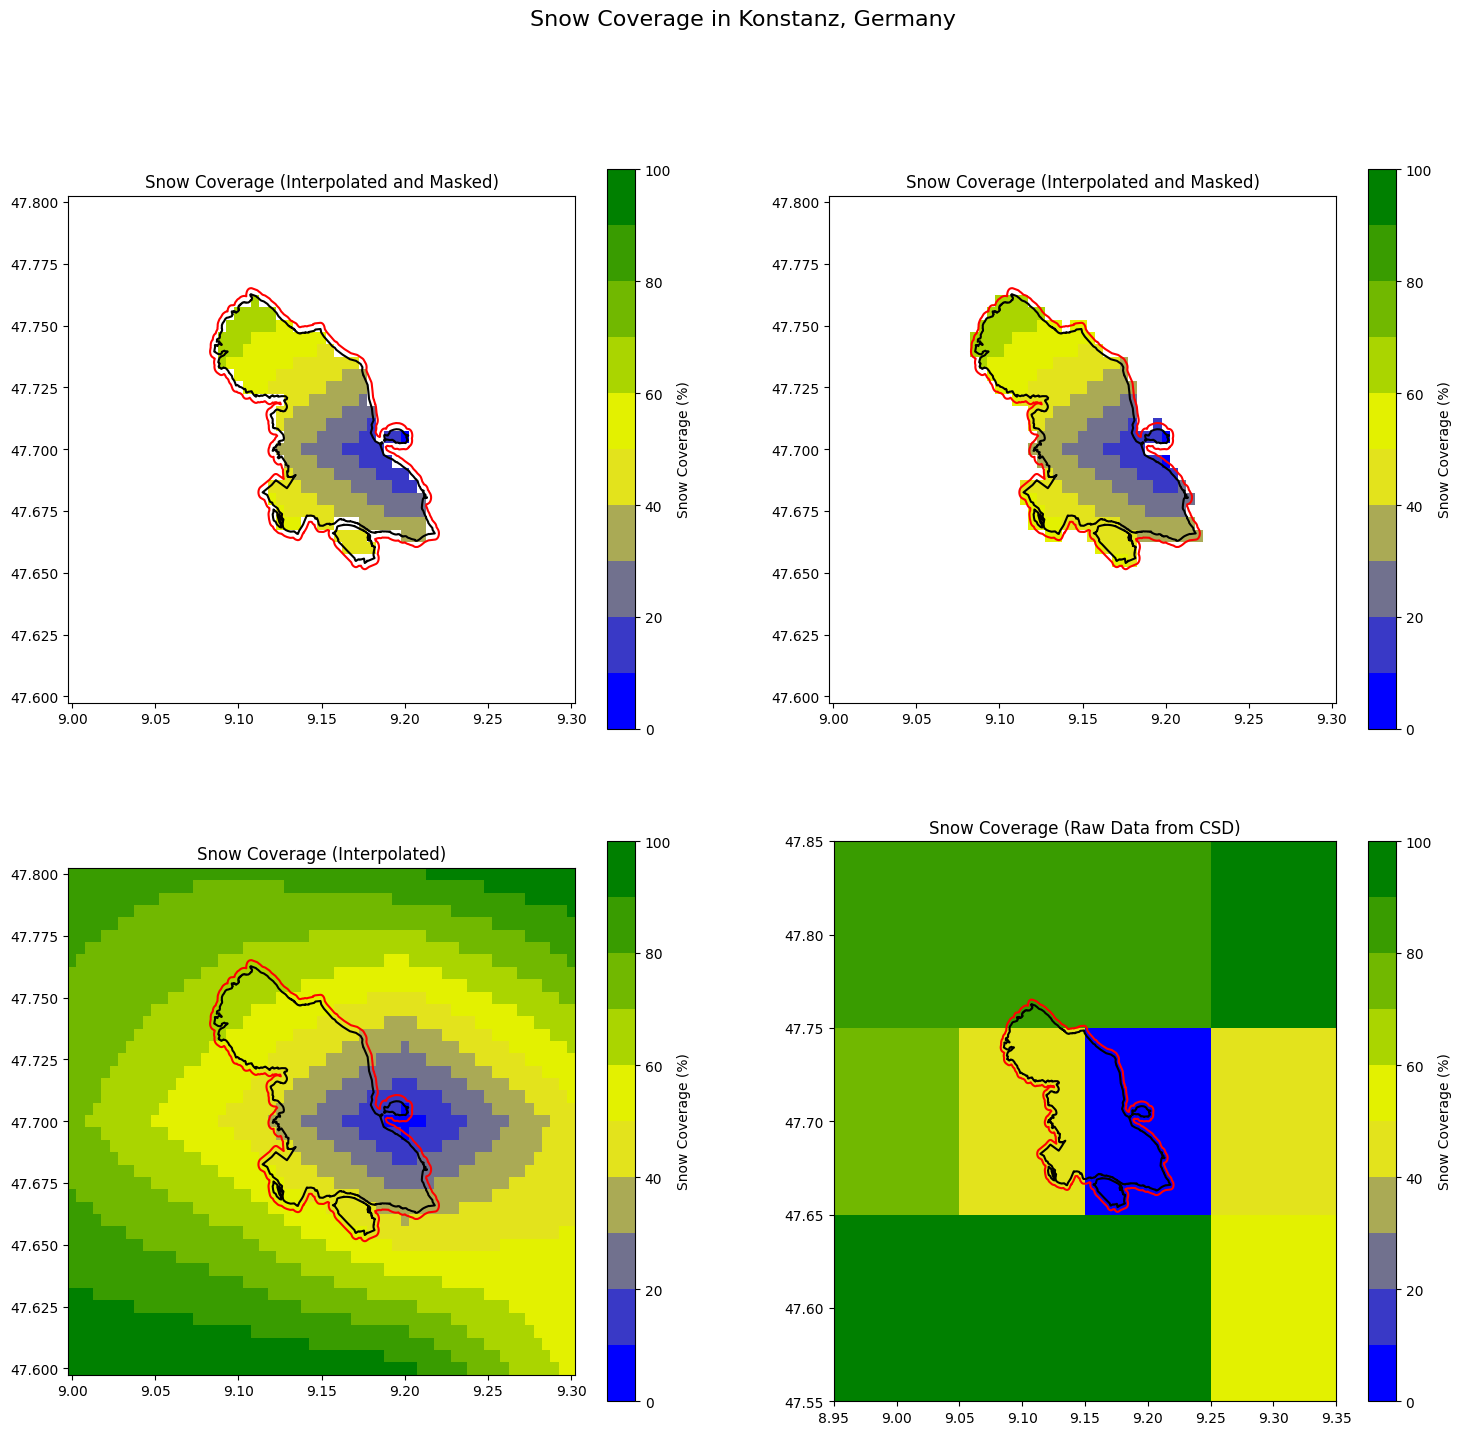

In [7]:
# Plot the masked data
fig, axs = plt.subplots(2, 2, figsize=(18, 16))

###
ax =  axs[0, 0]
mesh = ax.pcolormesh(lon_new, lat_new, masked_data, cmap=cmap, vmin=0, vmax=100)
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')
ax.set_title('Snow Coverage (Interpolated and Masked)')
ax.set_aspect(1)
germany_boundary.boundary.plot(ax=ax, edgecolor='black')
germany_boundary_buffered.boundary.plot(ax=ax, edgecolor='red')

##
ax =  axs[0, 1]
mesh = ax.pcolormesh(lon_new, lat_new, masked_data_buffered, cmap=cmap, vmin=0, vmax=100)
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')
ax.set_title('Snow Coverage (Interpolated and Masked)')
ax.set_aspect(1)
germany_boundary.boundary.plot(ax=ax, edgecolor='black')
germany_boundary_buffered.boundary.plot(ax=ax, edgecolor='red')

###
ax =  axs[1, 0]
mesh = ax.pcolormesh(lon_new, lat_new, interpolated_data, cmap=cmap, vmin=0, vmax=100)
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')
ax.set_title('Snow Coverage (Interpolated)')
ax.set_aspect(1)
germany_boundary.boundary.plot(ax=ax, edgecolor='black')
germany_boundary_buffered.boundary.plot(ax=ax, edgecolor='red')

###
ax =  axs[1, 1]
mesh = ax.pcolormesh(lon_list, lat_list, band_data, cmap=cmap, vmin=0, vmax=100)
plt.colorbar(mesh, ax=ax, label='Snow Coverage (%)')
ax.set_title('Snow Coverage (Raw Data from CSD)')
ax.set_aspect(1)
germany_boundary.boundary.plot(ax=ax, edgecolor='black')
germany_boundary_buffered.boundary.plot(ax=ax, edgecolor='red')
fig.suptitle('Snow Coverage in Konstanz, Germany', fontsize=16)

# Show the plot
plt.show()

## Create df

In [8]:
mean_nomask_list = []
mean_masked_list = []

total_bands = [(index) for index in range(np.shape(variable_data)[0])]
year_list = [(band_index//12)+1950 for band_index in total_bands]
month_list = [(band_index % 12) + 1 for band_index in total_bands]

for band_index in total_bands:
    band_data = variable_data[band_index,:,:]
    
    interpolator = RegularGridInterpolator((lat_list[:], lon_list[:]),
                                           band_data,
                                           method='linear',
                                           bounds_error=False,
                                           fill_value=None)
    
    interpolated_data = interpolator((lat_new, lon_new))
    masked_data = np.where(mask, interpolated_data, np.nan)
    
    mean_nomask_list.append(np.nanmean(band_data))
    mean_masked_list.append(np.nanmean(masked_data))
    
import pandas as pd

df_data = {
    'year': year_list,
    'month': month_list,
    'mean_nomask': mean_nomask_list,
    'mean_masked': mean_masked_list,
}

df = pd.DataFrame(df_data)
# df.head()
df

year  month  mean_nomask  mean_masked
0    1950      1    35.240559    18.994438
1    1950      2    17.616049     9.684011
2    1950      3     9.791179     5.372391
3    1950      4     0.661133     0.314395
4    1950      5     0.001465     0.001304
..    ...    ...          ...          ...
893  2024      6     0.000000     0.000000
894  2024      7     0.000000     0.000000
895  2024      8     0.000000     0.000000
896  2024      9     0.000000     0.000000
897  2024     10     0.000000     0.000000

[898 rows x 4 columns]

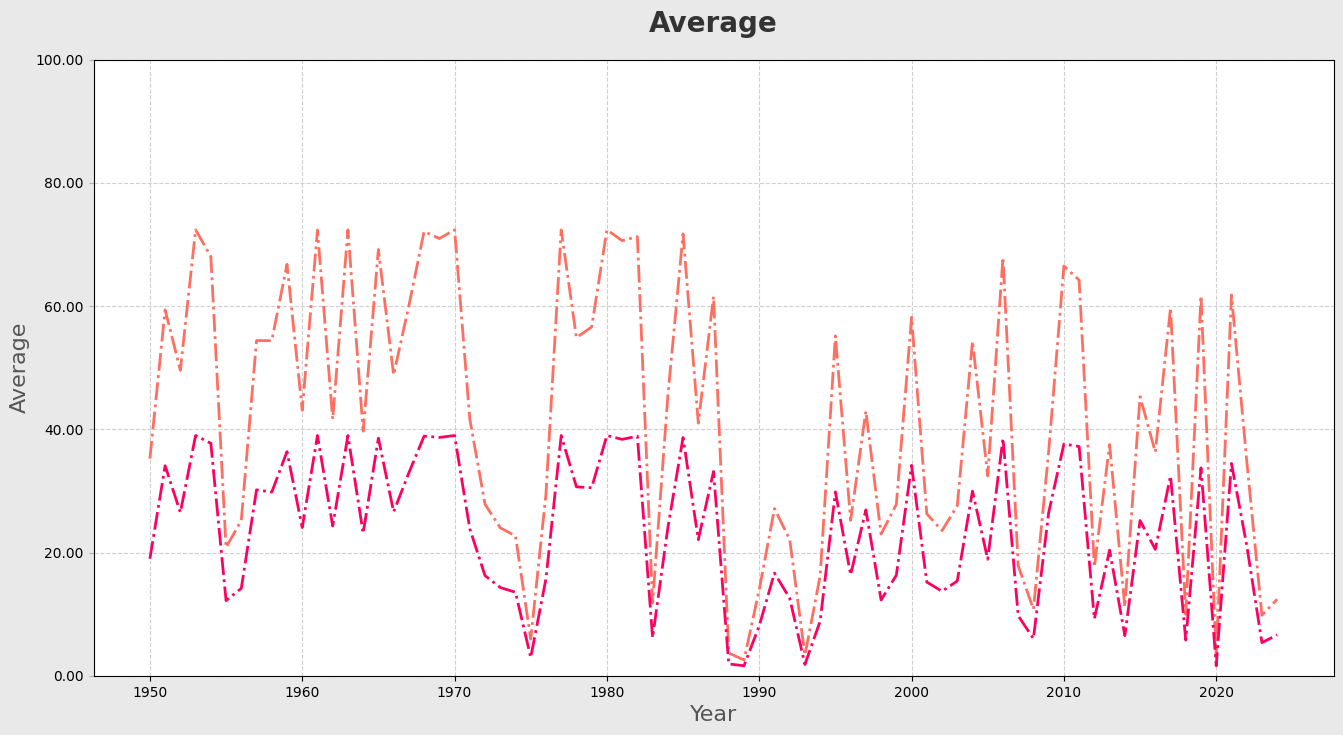

In [9]:
filtered_df = df[df['month']==1]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16, 8), facecolor='#e9e9e9', edgecolor='k')

# Titles and labels
ax.set_title("Average", fontsize=20, fontweight='bold', color='#333333', pad=20)
ax.set_xlabel("Year", fontsize=16, color='#555555')
ax.set_ylabel("Average", fontsize=16, color='#555555')
params = {
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,    
}
plt.rcParams.update(params)

# Grids and ticks
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.tick_params(axis='y', which='both', color='#b0b0b0')
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylim(0,100)

line1, = ax.plot(filtered_df['year'],
                 filtered_df['mean_nomask'].astype(float),
                 label='Mean (No Mask, Konstanz)',
                 color='#ff6f61',
                 linestyle='-.',
                 linewidth=2.0)

line2, = ax.plot(filtered_df['year'],
                 filtered_df['mean_masked'].astype(float),
                 label='Mean (masked, Konstanz)',
                 color='#ff0061',
                 linestyle='-.',
                 linewidth=2.0)